Check first if a GPU is installed

In [ ]:
!nvidia-smi

Tue Jan 21 13:45:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Training Split

In [ ]:
# import numpy as np
# import pandas as pd
# import os

# base_path = "/content/drive/Shareddrives/thesis/dataset/"

# clips = pd.read_csv(base_path + "Summary of Dataset Information - Clips.csv")

# def get_frame_count(path):
#   count = os.popen(f"ffprobe -v error -select_streams v:0 -count_frames -show_entries stream=nb_read_frames -of csv=p=0 {path}").read()
#   return count.strip()

# clips["Full Path"] = base_path + "split/Shoplifting/" + clips["Parent Video"] + "/" + clips["Filename"]
# clips["Frame Count"] = clips["Full Path"].apply(get_frame_count)
# print(clips["Frame Count"].head())

# #remove clips with fewer than 120 frames
# filtered_clips = clips[clips["Frame Count"] == '120']

# print(clips.shape[0])
# print(filtered_clips.shape[0])

In [ ]:
# from sklearn.model_selection import train_test_split

# filtered_clips = filtered_clips.drop(columns=["Full Path"])

# train, test = train_test_split(filtered_clips, test_size=0.2, stratify=filtered_clips["Label"], random_state=71)

# #TODO: make new coptadd augmented clips

# print(train.shape[0])
# print(test.shape[0])

# #save validation and train split
# test.to_csv(base_path + "test.csv", index=False)
# train.to_csv(base_path + "train.csv", index=False)

In [ ]:
# import pandas as pd
# from sklearn.utils import shuffle

# base_path = "/content/drive/Shareddrives/thesis/dataset/"

# train_csv = pd.read_csv(base_path + "augmented_train.csv")
# train_csv = shuffle(train_csv, random_state=18)
# train_csv.to_csv(base_path + "augmented_train.csv", index=False)

##Model

##Data Loader

In [ ]:
import torch
import torchvision
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class BaseDataset(Dataset):
  def __init__(self, frames_per_clip=90, train=True, transform=None, source='Original', lstm_format=False):
    if source not in ['Original', 'YOLO', 'Openpose']:
      raise RuntimeError("Invalid source. Should be one of 'Original', 'YOLO', or 'Openpose'")
    #load data
    base_path = "/content/drive/Shareddrives/thesis/dataset/"
    file_path = "augmented_train.csv" if train else "test.csv"
    self.fpc = frames_per_clip
    self.data = pd.read_csv(base_path + file_path)
    self.targets = self.data["Label"].values
    self.transform = transform
    self.source = source
    self.lstm_format = lstm_format

  def __len__(self):
    return len(self.data)

  def make_tensor(self, frames):
    #To do: normalize frames
    frames_tensor = torch.stack([torch.from_numpy(frame) for frame in frames])
    #frames have shape (n_frames, width, height, channels)
    if self.lstm_format:
      frames_tensor = frames_tensor.permute(0,3,1,2)
    else:
      frames_tensor = frames_tensor.permute(3,0,1,2)
    frames_tensor = frames_tensor.type(torch.float32)
    if self.transform:
      frames_tensor = self.transform(frames_tensor)
    return frames_tensor


class FrameDataset(BaseDataset):
  def __getitem__(self, x):
      frames = []
        # for frames
      if self.source == 'YOLO':
        # base_path = "/content/drive/Shareddrives/shoplifting-detection/pose_estimation_results/YOLO"
        base_path = "/content/drive/Shareddrives/shoplifting-dataset/pose_estimation_results_70/YOLOv70"
        frames_path = os.path.join(base_path, self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"].removesuffix(".mp4"), "frames")
      else:
        base_path = "/content/drive/Shareddrives/shoplifting-detection/dataset/Frames/Shoplifting"
        frames_path = os.path.join(base_path, self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"])
      total_frames = self.data.loc[x, "Frame Count"]
      #total_frames = len(os.listdir(frames_path))
      frames_indexes = np.linspace(0, total_frames - 1, self.fpc, dtype=int)

      #in case of missing frames in YOLO output
      split_path = os.path.join("/content/drive/Shareddrives/shoplifting-detection/dataset/Frames/Shoplifting",
                                  self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"])

      for ind in frames_indexes:
        image = cv2.imread(frames_path + f"/frame_{ind}.jpg")
        if image is not None:
          frames.append(image)
        else:
          image = cv2.imread(split_path + f"/frame_{ind}.jpg")
          if image is not None:
            frames.append(image)
          else:
            print(f"frame_{ind}.jpg cannot be found for {self.data.loc[x, 'Filename']}")

      if frames == [] or len(frames) < self.fpc:
        # no frames or some missing
        raise ValueError(f"{self.fpc - len(frames)} missing frames for {self.data.loc[x, 'Filename']}")

      frames_tensor = self.make_tensor(frames)
      label = torch.tensor([self.data.loc[x, "Label"]], dtype=torch.float32)
      index = torch.tensor([x])
      return index, frames_tensor, label

class ClipDataset(BaseDataset):
  def __getitem__(self, x):
      frames = []
      if self.source == 'YOLO':
        base_path = "/content/drive/Shareddrives/shoplifting-dataset/pose_estimation_results_70/YOLOv70"
        file_path = os.path.join(base_path, self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"].removesuffix(".mp4"), self.data.loc[x, "Filename"].removesuffix(".mp4") +"+poses.mp4")
      else:
        base_path = "/content/drive/Shareddrives/thesis/dataset"
        file_path = os.path.join(base_path, "split", "Shoplifting", self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"])

      vidcap = cv2.VideoCapture(file_path)
      total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
      # total_frames = self.data.loc[x, "Frame Count"]
      frames_indexes = np.linspace(0, total_frames - 1, self.fpc, dtype=int)
      print(total_frames)
      print(frames_indexes)

      for ind in frames_indexes:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, ind)
        success, image = vidcap.read()
        if success:
          frames.append(image)
        else:
          print(f"frame_{ind}.jpg cannot be found for {self.data.loc[x, 'Filename']}")
      vidcap.release()

      if frames == [] or len(frames) < self.fpc:
        # no frames found in folder
        raise ValueError(f"{self.fpc - len(frames)} missing frames for {self.data.loc[x, 'Filename']}")

      frames_tensor = self.make_tensor(frames)
      label = torch.tensor([self.data.loc[x, "Label"]], dtype=torch.float32)
      index = torch.tensor([x])
      return index, frames_tensor, label


In [ ]:
torch.manual_seed(1337) #for reproducibility
batch_size = 4
train_dataset = ClipDataset(train=True, source='YOLO')
test_dataset = ClipDataset(train=False, source='YOLO')
# train_dataset = FrameDataset(train=True, source='YOLO')
# test_dataset = FrameDataset(train=False, source='YOLO')
labels = torch.tensor(train_dataset.targets)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4)

In [ ]:
name, image, label = train_dataset[0]
print(name.shape)
print(image.shape)
print(label.shape)
train_iter = iter(train_dataloader)
names, images, labels = next(train_iter)
print(names.shape)
print(images.shape)
print(labels.shape)

torch.Size([1])
torch.Size([3, 90, 240, 320])
torch.Size([1])
torch.Size([4, 1])
torch.Size([4, 3, 90, 240, 320])
torch.Size([4, 1])


##3D CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

class ConvNet3D(nn.Module):

  def __init__(self, input_dim, output_dim=1):
    #Input should have shape (channels, frames, height, width)
    super(ConvNet3D, self).__init__()
    #Convolutional Layers
    self.conv1 = nn.Conv3d(input_dim[0], 16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
    #self.norm1 = nn.BatchNorm3d(16)
    self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
    #self.norm2 = nn.BatchNorm3d(32)
    self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
    #self.norm3 = nn.BatchNorm3d(64)

    #Fully Connected Layers
    fc_input_size = 64 * (input_dim[1] // 8) * (input_dim[2] // 8) * (input_dim[3] // 8)
    self.fc1 = nn.Linear(fc_input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, output_dim)

    self.sig = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    # out = self.pool(F.relu(self.norm1(self.conv1(x))))
    # out = self.pool(F.relu(self.norm2(self.conv2(out))))
    #out = self.dropout(out)
    # out = self.pool(F.relu(self.norm3(self.conv3(out))))
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.pool(F.relu(self.conv3(out)))
    fc_input_size = 64 * (input_dim[1] // 8) * (input_dim[2] // 8) * (input_dim[3] // 8)
    out = out.view(-1, fc_input_size)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

## Training

In [ ]:
!pip install ipdb

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 30
n_samples = len(train_dataset)
n_iterations = ceil(n_samples / batch_size)

input_dim = (3, 90, 240, 320)
model = ConvNet3D(input_dim)

# Calculate pos_weight based on class imbalance
pos_weight = torch.tensor([1910 / 231]) #manually counted
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model = model.to(device)

# Load a previously saved checkpoint (if resuming)
checkpoint_file = 'third_model_checkpoint.pth'
checkpoint_dir = '/content/drive/Shareddrives/thesis/models/checkpoints/'
checkpoint_path = checkpoint_dir + checkpoint_file
!mkdir -p $checkpoint_dir
start_epoch = 0
start_batch = 0
epoch_loss = [] #loss for each batch
train_loss = [] #gets average of epoch_loss every epoch
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    start_batch = checkpoint['batch']
    train_loss = checkpoint['train_loss']
    epoch_loss = checkpoint['epoch_loss']
    print(f"Resuming training from epoch {start_epoch + 1}, batch {start_batch}")
except FileNotFoundError:
    print("Starting training from scratch.")

# clips_without_frames = set()
# clips_without_frames.add

# Training loop
for epoch in range(start_epoch, n_epochs):
  #current_lr = scheduler.get_last_lr()[0]
  #print(f"Current Learning Rate: {current_lr}")
  for i, (_, inputs, labels) in enumerate(train_dataloader):
    if epoch == start_epoch and i < start_batch:
      if i % 32 == 0:
        print(f"skipping batch {i}")
      continue
    if (i + 1) % 32 == 0: print(f"training for batch {i + 1}/{n_iterations}")

    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = model(inputs)

    # calculate loss
    optimizer.zero_grad()
    loss = criterion(preds, labels)
    epoch_loss.append(loss.item())

    #update weights
    loss.backward()
    optimizer.step()

    # Save a checkpoint every 128 batches
    if (i + 1) % 128 == 0:
      print(f"epoch {epoch + 1}/{n_epochs}, batch {i + 1}/{n_iterations}, loss={loss.item()}")
      print(f"saving model")
      torch.save({
          'epoch': epoch,
          'batch': i + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'epoch_loss': epoch_loss,
          'train_loss': train_loss,
          # 'scheduler_state_dict': scheduler.state_dict(),
      }, checkpoint_path)
      print("saved model")


  # save after epoch
  train_loss.append(sum(epoch_loss) / len(epoch_loss))
  epoch_loss = []
  print(f"epoch {epoch + 1}, training_loss = {train_loss[-1]}")
  print("saving model")
  torch.save({
            'epoch': epoch + 1,
            'batch': 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch_loss': [],
            'train_loss': train_loss,
            #'scheduler_state_dict': scheduler.state_dict(),
        }, checkpoint_path)
  # scheduler.step(loss)
  print("saved model")


<ipython-input-16-02eb21604161>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 18, batch 0
training for batch 32/824
training for batch 64/824
training for batch 96/824
training for batch 128/824
epoch 18/30, batch 128/824, loss=1.5493531227111816
saving model
saved model
training for batch 160/824
training for batch 192/824
training for batch 224/824
training for batch 256/824
epoch 18/30, batch 256/824, loss=0.5264851450920105
saving model
saved model
training for batch 288/824
training for batch 320/824
training for batch 352/824
training for batch 384/824
epoch 18/30, batch 384/824, loss=0.00031199908698908985
saving model
saved model
training for batch 416/824
training for batch 448/824
training for batch 480/824
training for batch 512/824
epoch 18/30, batch 512/824, loss=0.3086000084877014
saving model
saved model
training for batch 544/824
training for batch 576/824
training for batch 608/824
training for batch 640/824
epoch 18/30, batch 640/824, loss=0.6599625945091248
saving model
saved model
training for batch 672/824
traini

## Testing

In [ ]:
import torch
# validation
input_dim = (3, 90, 240, 320)
model = ConvNet3D(input_dim)
threshold = 0.4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load model
checkpoint_file = 'third_model_checkpoint.pth'
checkpoint_path = '/content/drive/Shareddrives/thesis/models/checkpoints/' + checkpoint_file
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

indices_all = []
y_true_all = []
y_pred_all = []
y_prob_all = []
n_iterations = ceil(len(test_dataset) / batch_size)

with torch.no_grad():
  for batch, (indices, inputs, labels) in enumerate(test_dataloader):
    if (batch + 1) % 10 == 0: print(f"testing for batch {batch + 1}/{n_iterations}")
    inputs = inputs.to(device)

    outputs = torch.sigmoid(model(inputs))
    rounded = (outputs > threshold).int()

    indices_all.extend(indices.numpy())
    y_true_all.extend(labels.numpy())
    y_prob_all.extend(outputs.cpu().numpy())
    y_pred_all.extend(rounded.cpu().numpy())
  print(f'tested all {n_iterations} batches')


<ipython-input-18-0ee319781b84>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


testing for batch 10/134
testing for batch 20/134
testing for batch 30/134
testing for batch 40/134
testing for batch 50/134
testing for batch 60/134
testing for batch 70/134
testing for batch 80/134
testing for batch 90/134
testing for batch 100/134
testing for batch 110/134
testing for batch 120/134
testing for batch 130/134
tested all 134 batches


In [ ]:
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []

def calculate_metrics(inds, preds, labels):
    TP = (preds == 1) & (labels == 1)
    TN = (preds == 0) & (labels == 0)
    FP = (preds == 1) & (labels == 0)
    FN = (preds == 0) & (labels == 1)

    true_positives.extend(inds[TP].tolist())
    true_negatives.extend(inds[TN].tolist())
    false_positives.extend(inds[FP].tolist())
    false_negatives.extend(inds[FN].tolist())

    TP = torch.sum(TP).item()
    TN = torch.sum(TN).item()
    FP = torch.sum(FP).item()
    FN = torch.sum(FN).item()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

metrics = calculate_metrics(torch.tensor(indices_all), torch.tensor(y_pred_all), torch.tensor(y_true_all))
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")

Accuracy: 0.8209
Precision: 0.3173
Recall: 0.5690
F1 Score: 0.4074


<ipython-input-19-364c59edf9ce>:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  metrics = calculate_metrics(torch.tensor(indices_all), torch.tensor(y_pred_all), torch.tensor(y_true_all))


In [ ]:
precision = [0,0]
accuracy = [0,0]
recall = [0,0]
f1 = [0,0]
for threshold in torch.arange(0.05, 1, 0.05):
  y_pred_test = (torch.tensor(y_prob_all) > threshold).int()
  metrics = calculate_metrics(torch.tensor(indices_all), torch.tensor(y_pred_all), torch.tensor(y_true_all))
  if precision[1] < metrics['precision']:
    precision = [threshold, metrics['precision']]
  if accuracy[1] < metrics['accuracy']:
    accuracy = [threshold, metrics['accuracy']]
  if recall[1] < metrics['recall']:
    recall = [threshold, metrics['recall']]
  if f1[1] < metrics['f1']:
    f1 = [threshold, metrics['f1']]
print(precision)
print(accuracy)
print(recall)
print(f1)

[tensor(0.0500), 0.3173076923076923]
[tensor(0.0500), 0.8208955223880597]
[tensor(0.0500), 0.5689655172413793]
[tensor(0.0500), 0.4074074074074074]


In [ ]:
y_prob_all = np.array(y_prob_all)
print(y_prob_all.mean(), y_prob_all.max())

0.30212513 1.0


In [ ]:
base_path = "/content/drive/Shareddrives/thesis/dataset/"
file_path = "test.csv"
data = pd.read_csv(base_path + file_path)['Filename']
false_positive_names = data.iloc[false_positives]
false_negative_names = data.iloc[false_negatives]
true_positive_names = data.iloc[true_positives]
true_negative_names = data.iloc[true_negatives]
print('True Positives: ')
print(true_positive_names.head())
print('False Negatives: ')
print(false_negative_names.head())
print('False Positives')
print(false_positive_names.head())

with open(f"{checkpoint_path.removesuffix('.pth')}_predictions.txt", 'w') as f:
  f.write("False Positives: \n")
  for item in false_positive_names:
    f.write(f"{item}\n")
  f.write("\nFalse Negatives: \n")
  for item in false_negative_names:
    f.write(f"{item}\n")
  f.write("\nTrue Positives: \n")
  for item in true_positive_names:
    f.write(f"{item}\n")
  f.write("\nTrue Negatives: \n")
  for item in true_negative_names:
    f.write(f"{item}\n")


True Positives: 
1     Shoplifting028_x264_4.mp4
35    Shoplifting026_x264_4.mp4
37    Shoplifting013_x264_7.mp4
62    Shoplifting018_x264_3.mp4
80    Shoplifting018_x264_9.mp4
Name: Filename, dtype: object
False Negatives: 
36    Shoplifting040_x264_16.mp4
52     Shoplifting029_x264_9.mp4
86    Shoplifting043_x264_51.mp4
94    Shoplifting034_x264_54.mp4
97     Shoplifting037_x264_9.mp4
Name: Filename, dtype: object
False Positives
26    Shoplifting041_x264_11.mp4
46    Shoplifting041_x264_69.mp4
57    Shoplifting048_x264_10.mp4
83     Shoplifting055_x264_2.mp4
91    Shoplifting003_x264_76.mp4
Name: Filename, dtype: object


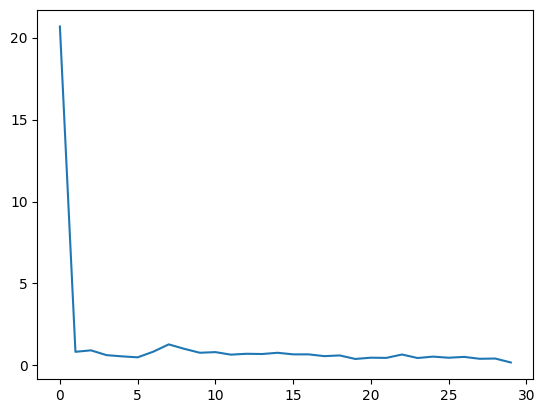

In [ ]:
import matplotlib.pyplot as plt
training_loss = checkpoint['train_loss']
plt.plot(training_loss)

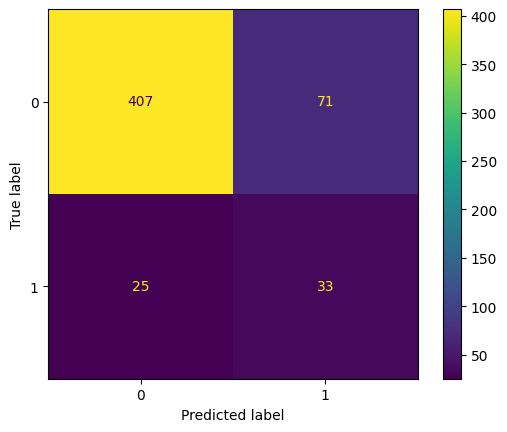

In [ ]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_true_all, y_pred_all)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

##Timing

In [ ]:
import torch
# validation
input_dim = (3, 90, 240, 320)
model = ConvNet3D(input_dim)
threshold = 0.4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load model
checkpoint_file = 'third_model_checkpoint.pth'
checkpoint_path = '/content/drive/Shareddrives/thesis/models/checkpoints/' + checkpoint_file
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

<ipython-input-3-51490f4fb012>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
import torch
import torchvision
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class BaseDataset(Dataset):
  def __init__(self, frames_per_clip=90, train=True, transform=None, source='Original', lstm_format=False):
    if source not in ['Original', 'YOLO', 'Openpose']:
      raise RuntimeError("Invalid source. Should be one of 'Original', 'YOLO', or 'Openpose'")
    #load data
    base_path = "/content/drive/Shareddrives/thesis/dataset/"
    file_path = "train.csv" if train else "test.csv"
    self.fpc = frames_per_clip
    self.data = pd.read_csv(base_path + file_path)
    self.targets = self.data["Label"].values
    self.transform = transform
    self.source = source
    self.lstm_format = lstm_format

  def __len__(self):
    return len(self.data)

  def make_tensor(self, frames):
    #To do: normalize frames
    frames_tensor = torch.stack([torch.from_numpy(frame) for frame in frames])
    #frames have shape (n_frames, width, height, channels)
    if self.lstm_format:
      frames_tensor = frames_tensor.permute(0,3,1,2)
    else:
      frames_tensor = frames_tensor.permute(3,0,1,2)
    frames_tensor = frames_tensor.type(torch.float32)
    if self.transform:
      frames_tensor = self.transform(frames_tensor)
    return frames_tensor

class ClipDataset(BaseDataset):
  def __getitem__(self, x):
      frames = []
      if self.source == 'YOLO':
        base_path = "/content/drive/Shareddrives/shoplifting-detection/pose_estimation_results/YOLO"
        file_path = os.path.join(base_path, self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"].removesuffix(".mp4"), self.data.loc[x, "Filename"].removesuffix(".mp4") +"+poses.mp4")
      else:
        base_path = "/content/drive/Shareddrives/thesis/dataset"
        file_path = os.path.join(base_path, "split", "Shoplifting", self.data.loc[x, "Parent Video"], self.data.loc[x, "Filename"])

      vidcap = cv2.VideoCapture(file_path)
      total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
      # total_frames = self.data.loc[x, "Frame Count"]
      frames_indexes = np.linspace(0, total_frames - 1, self.fpc, dtype=int)

      for ind in frames_indexes:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, ind)
        success, image = vidcap.read()
        if success:
          frames.append(image)
        else:
          print(f"frame_{ind}.jpg cannot be found for {self.data.loc[x, 'Filename']}")
      vidcap.release()

      if frames == [] or len(frames) < self.fpc:
        # no frames found in folder
        raise ValueError(f"{total_frames - len(frames)} missing frames for {self.data.loc[x, 'Filename']}")

      frames_tensor = self.make_tensor(frames)
      label = torch.tensor([self.data.loc[x, "Label"]], dtype=torch.float32)
      index = torch.tensor([x])
      return index, frames_tensor, label


In [ ]:
test_dataset = ClipDataset(train=False, source='YOLO')
_, frames, _ = test_dataset[20]
frames = frames.to(device).unsqueeze(0)
frames.shape

torch.Size([1, 3, 90, 240, 320])

In [ ]:
%%timeit
with torch.inference_mode():
  output = model(frames)
  torch.cuda.empty_cache()

53.6 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
